In [1]:
# import statements
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import pingouin as pg
from statsmodels.tsa.stattools import acf
import toolbox

# set color bar
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255),
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Load RO data

In [2]:
# load zonal mean temperature data and the tropopause
zm_temp = xr.open_dataset('/home/disk/p/aodhan/GNSSTrends/Data/GNSS_Gridded_ZonalMean_7.5_20230601.nc')
lrz = np.load('/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/Data/lrz_maps_zm_annual_mean.npy')

# get array of just temperature
zm_temp_array = zm_temp.temperature.values[:,:,:,0]
copy = zm_temp_array[0]
copy[:] = np.nan

# pad data at the beginning and end of record with nans so we have a full 23 years
nans_beginning = np.broadcast_to([copy], (4,201,24))
nans_end = np.broadcast_to([copy], (8,201,24))
zm_temp_array_with_nans = np.concatenate([nans_beginning, zm_temp_array, nans_end], axis=0)

# find climatology and anomalies
temperature_calendar = np.reshape(zm_temp_array_with_nans, (23,12,201,24))[1:-1] #this trims first and last year of data which are not complete
temperature_anomalies = temperature_calendar - np.nanmean(temperature_calendar, axis=0) # remove seasonality
temperature_anomalies_ts = np.reshape(temperature_anomalies, (21*12, temperature_anomalies.shape[2], temperature_anomalies.shape[3]))

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


## Remove QBO and ENSO and Find Trends

In [3]:
# load ENSO and QBO indices
enso = pd.read_csv('/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/Data/meiv2_adjusted.data', sep="    ", header=None)
enso_calendar = [list(enso.iloc[i].values) for i in range(0,len(enso))][22:44]
enso_ts = np.ravel(enso_calendar)[9:-3]
qbo = pd.read_csv('/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/Data/QBO_EOF_coeff.txt', delim_whitespace=True)
qbo = qbo[(qbo['Year'] >= 2002) & (qbo['Year'] <= 2022)]
qbo_eof1 = qbo['EOF-1'].values
qbo_eof2 = qbo['EOF-2'].values

# do MLR regression
temp_anoms_No_QBO_ENSO = toolbox.ENSO_QBO_remover(temperature_anomalies_ts, enso_ts, qbo_eof1, qbo_eof2)

# rearange the array and get trends
temp_anoms_No_QBO_ENSO_sx = np.swapaxes(temp_anoms_No_QBO_ENSO, 0,2)
temp_anoms_No_QBO_ENSO_sxx = np.swapaxes(temp_anoms_No_QBO_ENSO_sx, 1,2)

# get trends
map_of_trends = toolbox.annual_trend_finder(temp_anoms_No_QBO_ENSO_sxx)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


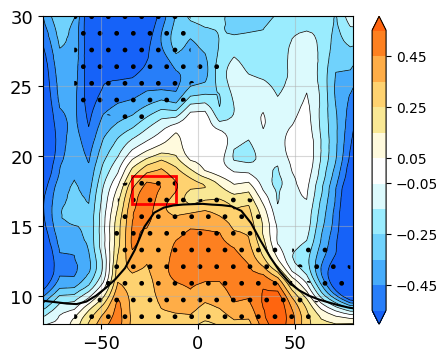

In [4]:
# define contour levels (using same as IPCC figure)
levels = np.arange(-0.55,0.551,.1)

# plot trend contour with colorbar
plt.figure(figsize=(5,4))
plt.contour(zm_temp.lat, zm_temp.alt, map_of_trends[:,:,0], 
            levels=levels, colors='black', extend='both', 
            linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
plt.contourf(zm_temp.lat, zm_temp.alt, map_of_trends[:,:,0], 
             levels=levels,cmap=custom_cmap, extend='both')
cbar = plt.colorbar()
cbar.set_ticks(np.array([-0.45,-0.25, -0.05, 0.05, 0.25,0.45]))

# add signficance
plt.contourf(zm_temp.lat, zm_temp.alt, map_of_trends[:,:,1], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])

# add lapse-rate tropopause
plt.plot(np.arange(-87.5,87.51,5), lrz, color='black')

# add rectangle patch for AWLS region
rect = patches.Rectangle((-33.75, 16.6), 22.5, 2, linewidth=2, edgecolor='red', facecolor='none')
plt.gca().add_patch(rect)

# set extra plotting parameters
plt.ylim(8,30)
plt.xlim(-80,80)
plt.grid(alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=13)
#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/ROJulDecColorbar.png', dpi=300)

In [5]:
print('AWLS \n==========')
print('Height Red Box: ', zm_temp.alt[83:94].values[0], 'to', zm_temp.alt[83:94].values[-1])
print('Lat Red Box: ', zm_temp.lat[7:11].values[0], 'to', zm_temp.lat[7:11].values[-1])
print('\nNH AWLS analogue \n==========')
print('Height Red Box: ', zm_temp.alt[83:94].values[0], 'to', zm_temp.alt[83:94].values[-1])
print('Lat Red Box: ', zm_temp.lat[13:17].values[0], 'to', zm_temp.lat[13:17].values[-1])
print('\nAntarctic \n==========')
print('Height Red Box: ', zm_temp.alt[65:86].values[0], 'to', zm_temp.alt[65:86].values[-1])
print('Lat Red Box: ', zm_temp.lat[:4].values[0], 'to', zm_temp.lat[:4].values[-1])
print('\nTropcial \n==========')
print('Height Red Box: ', zm_temp.alt[83:89].values[0], 'to', zm_temp.alt[83:89].values[-1])
print('Lat Red Box: ', zm_temp.lat[9:15].values[0], 'to', zm_temp.lat[9:15].values[-1])


AWLS 
Height Red Box:  16.6 to 18.6
Lat Red Box:  -33.75 to -11.25

NH AWLS analogue 
Height Red Box:  16.6 to 18.6
Lat Red Box:  11.25 to 33.75

Antarctic 
Height Red Box:  13.0 to 17.0
Lat Red Box:  -86.25 to -63.75

Tropcial 
Height Red Box:  16.6 to 17.6
Lat Red Box:  -18.75 to 18.75


In [6]:
# define AWLS ([:, 83-94, 7-11] means [:, 16.6 - 18.6 km, -33.75S - 11.25S]
anomalous_temp_in_box = temp_anoms_No_QBO_ENSO_sxx[:, 83:94, 7:11]

# get latitude weights and take weighted average
lat_weights = np.cos(np.deg2rad(zm_temp.lat[7:11].values))
anomalous_temp_in_box = np.multiply(anomalous_temp_in_box, lat_weights[np.newaxis, np.newaxis, :])
anomalous_temp_in_box = np.reshape(anomalous_temp_in_box, (len(anomalous_temp_in_box), 11*4))
anomalous_temp_in_box = np.nansum(anomalous_temp_in_box, axis=1)/(np.sum(lat_weights)*11)

# save the AWLS timeseries
#np.save('/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/Data/AWLS', anomalous_temp_in_box)

# get correlations
correlation_map, significance_map = toolbox.annual_corr_finder(temp_anoms_No_QBO_ENSO_sxx, 
                                                               anomalous_temp_in_box)

## Plot Correlation

(-80, 80)

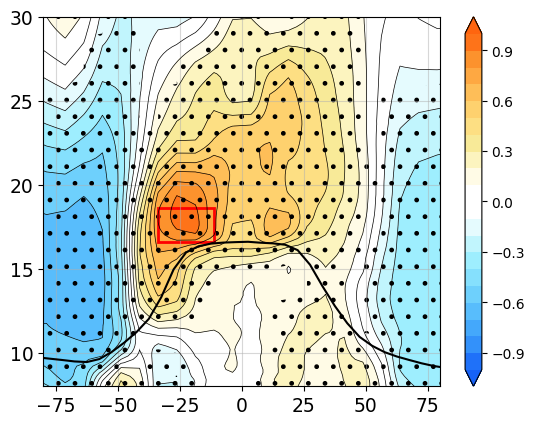

In [7]:
# set contour levels
levels = np.arange(-1,1.01,.1)

# plot correlation with colorbar
plt.contour(zm_temp.lat, zm_temp.alt, correlation_map.T, levels=levels, colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
plt.contourf(zm_temp.lat, zm_temp.alt, correlation_map.T, levels=levels, cmap=custom_cmap, extend='both')
plt.colorbar()

# add significance
plt.contourf(zm_temp.lat, zm_temp.alt, significance_map.T, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])

# add lapse rate tropopause
plt.plot(np.arange(-87.5,87.51,5), lrz, color='black')

# add rectangle for AWLS region
rect = patches.Rectangle((-33.75, 16.6), 22.5, 2, linewidth=2, edgecolor='red', facecolor='none')
plt.gca().add_patch(rect)

# set tick params
plt.tick_params(axis='both', which='major', labelsize=13.5)
y_vals = np.array([10, 15, 20, 25, 30])
plt.yticks(y_vals)

# include grid and set range
plt.grid(alpha=0.5)
plt.ylim(8,30)
plt.xlim(-80,80)

#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/NHBoxCorrelation.png', dpi=300)

(-80, 80)

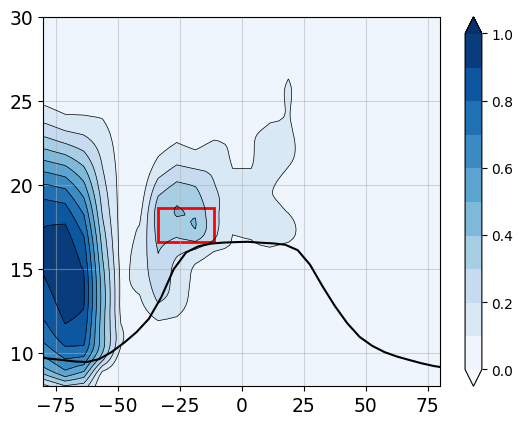

In [ ]:
# set contour levels
levels = np.arange(0,1.01,.1)

# plot correlation with colorbar
plt.contour(zm_temp.lat, zm_temp.alt, correlation_map.T**2, levels=levels, colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
plt.contourf(zm_temp.lat, zm_temp.alt, correlation_map.T**2, levels=levels, cmap='Blues', extend='both')
plt.colorbar()

# add significance
#plt.contourf(zm_temp.lat, zm_temp.alt, significance_map.T, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])

# add lapse rate tropopause
plt.plot(np.arange(-87.5,87.51,5), lrz, color='black')

# add rectangle for AWLS region
rect = patches.Rectangle((-33.75, 16.6), 22.5, 2, linewidth=2, edgecolor='red', facecolor='none')
plt.gca().add_patch(rect)

# set tick params
plt.tick_params(axis='both', which='major', labelsize=13.5)
y_vals = np.array([10, 15, 20, 25, 30])
plt.yticks(y_vals)

# include grid and set range
plt.grid(alpha=0.5)
plt.ylim(8,30)
plt.xlim(-80,80)

#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/NHBoxCorrelation.png', dpi=300)

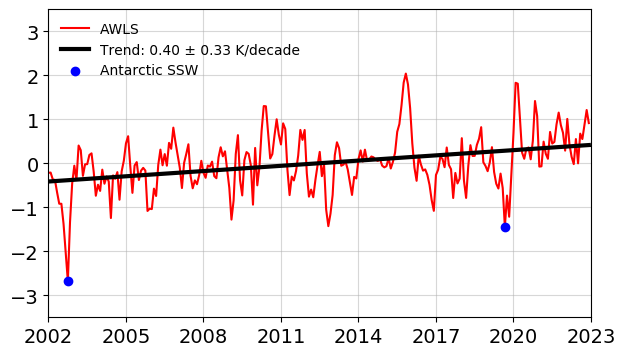

In [9]:
# regress AWLS against time & create trend line
time = np.arange(2002, 2023, 1/12)
lr = stats.linregress(time, anomalous_temp_in_box)
trend_line = lr[1] + lr[0]*time

# find residuals from trend line
errors = anomalous_temp_in_box - trend_line
time_errors = time - np.nanmean(time)

# find degrees of freedom with autocorrelation
N = len(anomalous_temp_in_box)
r1_autocorrelation = stats.pearsonr(anomalous_temp_in_box[1:], anomalous_temp_in_box[:-1])[0]
N_star = N*((1-r1_autocorrelation)/(1+r1_autocorrelation))

# find squared error in x and y
sum_squared_error_res = np.sum(np.square(errors))
var_errors = (1/N_star)*sum_squared_error_res
time_squared_error = np.sum(np.square(time_errors))

# find t-statistic
simga_slope_squared = var_errors/time_squared_error
sa = np.sqrt(simga_slope_squared)

# get critical t value
tcrit = stats.t.ppf(1-0.025, N_star)

# find confidence interval
ci_trend = tcrit*sa

# find degrees of freedom with autocorrelation
trend_label = f"Trend: {lr[0]*10:.2f} ± {ci_trend*10:.2f} K/decade"

# plot AWLS and trend
fig, axs = plt.subplots(1,1, figsize=(7,4))
plt.plot(time, anomalous_temp_in_box, color='red', label='AWLS')
plt.plot(time, trend_line, color='black', linewidth=3, label=trend_label)

# put Antarctic SSWs on plot
plt.scatter(time[9], anomalous_temp_in_box[9], color='blue', label='Antarctic SSW',zorder=5)
plt.scatter(time[8+(17*12)], anomalous_temp_in_box[8+(17*12)], color='blue',zorder=5)

# set x-ticks
plt.tick_params(axis='both', which='major', labelsize=14)
x_vals = np.arange(2002,2024,3)
axs.set_xticks(x_vals)
axs.set_xticklabels([str(year) for year in x_vals])

# include grid and set range
plt.xlim(2002,2023)
plt.ylim(-3.5,3.5)
plt.grid(alpha=0.5)
plt.legend(frameon=False, loc=0)


#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/AWLSTimeseries', dpi=300)

# Do Circulation Regression

In [10]:
# do circulation projection
projection_timeseries, map_sig = toolbox.annual_circ_regr(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box)
projection_timeseries = np.swapaxes(projection_timeseries, 0,2)
projection_timeseries = np.swapaxes(projection_timeseries, 1,2)
residual = temp_anoms_No_QBO_ENSO_sxx - projection_timeseries

#find trends
map_of_trends = toolbox.annual_trend_finder(temp_anoms_No_QBO_ENSO_sxx)
map_of_trends_projection = toolbox.annual_trend_finder(projection_timeseries)
map_of_trends_residual = toolbox.annual_trend_finder(residual)


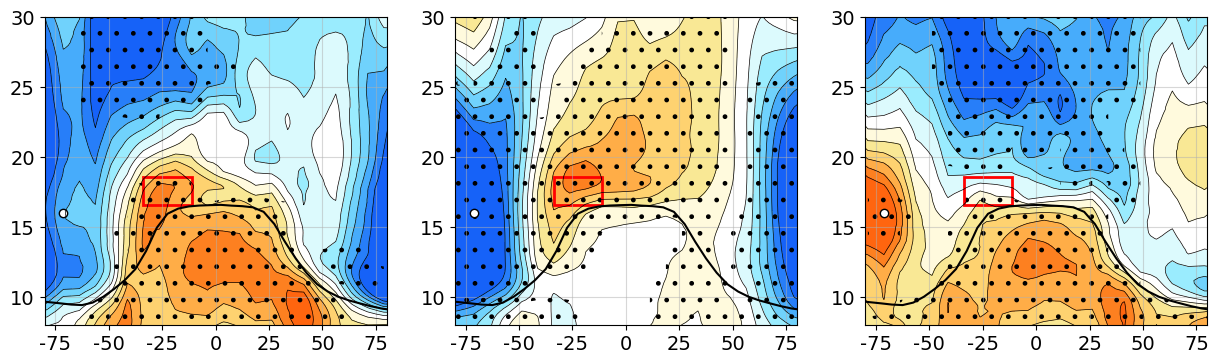

In [11]:
# set contour levels
levels = np.arange(-0.55,0.551,.1)

# define subplots
fig, axs = plt.subplots(1,3, figsize=(15,4))

# plot trends
axs[0].contour(zm_temp.lat, zm_temp.alt, map_of_trends[:,:,0], levels=levels, colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
axs[0].contourf(zm_temp.lat, zm_temp.alt, map_of_trends[:,:,0], levels=levels,cmap=custom_cmap, extend='both')
axs[0].contourf(zm_temp.lat, zm_temp.alt, map_of_trends[:,:,1], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])

# circulation regression
axs[1].contour(zm_temp.lat, zm_temp.alt, map_of_trends_projection[:,:,0], levels=levels, colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
axs[1].contourf(zm_temp.lat, zm_temp.alt, map_of_trends_projection[:,:,0], levels=levels, cmap=custom_cmap, extend='both')
axs[1].contourf(zm_temp.lat, zm_temp.alt, map_sig, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])

# residual
axs[2].contour(zm_temp.lat, zm_temp.alt, map_of_trends_residual[:,:,0], levels=levels, colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
axs[2].contourf(zm_temp.lat, zm_temp.alt, map_of_trends_residual[:,:,0], levels=levels,cmap=custom_cmap, extend='both')
axs[2].contourf(zm_temp.lat, zm_temp.alt, map_of_trends_residual[:,:,1], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])


# for each subplot, fix plotting range, include lrz, etc...
for i in range(3):
    axs[i].plot(np.arange(-87.5,87.51,5), lrz, color='black')
    rect = patches.Rectangle((-33.72, 16.6), 22.5, 2, linewidth=2, edgecolor='red', facecolor='none')
    axs[i].add_patch(rect)
    axs[i].set_ylim(8,30)
    axs[i].set_xlim(-80,80)
    axs[i].grid(alpha=0.5)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    x_vals = [-75, -50, -25, 0, 25, 50, 75]
    axs[i].set_xticks(x_vals)
    axs[i].set_xticklabels([str(year) for year in x_vals])
    axs[i].scatter(-71.25, 16,  edgecolor='black', facecolor='white')


    
#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/ROCirculationRegression_WhiteDot', dpi=300)

# Get Monthly Circulation Regression

In [ ]:
# perform monthly circulation regression
jan  = toolbox.monthly_circ_regr(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 0)
feb  = toolbox.monthly_circ_regr(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 1)
mar  = toolbox.monthly_circ_regr(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 2)
apr  = toolbox.monthly_circ_regr(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 3)
may  = toolbox.monthly_circ_regr(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 4)
jun  = toolbox.monthly_circ_regr(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 5)
jul  = toolbox.monthly_circ_regr(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 6)
aug  = toolbox.monthly_circ_regr(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 7)
sep  = toolbox.monthly_circ_regr(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 8)
occ  = toolbox.monthly_circ_regr(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 9)
nov  = toolbox.monthly_circ_regr(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 10)
dec  = toolbox.monthly_circ_regr(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 11)


/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/TrendAnalysis/toolbox.py:326: RuntimeWarning: divide by zero encountered in double_scalars
  (1+r1_autocorrelation))
/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/TrendAnalysis/toolbox.py:334: RuntimeWarning: divide by zero encountered in double_scalars
  t_stat_calculated = anom_trend/sa
/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/TrendAnalysis/toolbox.py:330: RuntimeWarning: divide by zero encountered in double_scalars
  var_errors = (1/N_star)*sum_squared_error_res
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_ms

In [ ]:
# only plot six months at a time
months1 = [jan, feb, mar, apr, may, jun]
months2 = [jul, aug, sep, occ, nov, dec]

# define levels as 2x the levels for the annual circulation regression
levels = np.arange(-0.55, 0.551,.1)*2

# create plot
fig, axs = plt.subplots(1,6, figsize=(30,5))
axes = axs.ravel()

# select part of year to plot, and trends, circ regr, or difference
months = months2
plot_idx = 0

for x in range(len(months1)):
    
    # for each month create contour plot
    axes[x].contour(zm_temp.lat, zm_temp.alt, months[x][:,:,plot_idx,0], levels=levels, 
                    colors='black', extend='both', linewidths=0.5, 
                    linestyles=np.where(levels >= 0, "-", "-"))
    axes[x].contourf(zm_temp.lat, zm_temp.alt,  months[x][:,:,plot_idx,0], levels=levels, 
                     cmap=custom_cmap, extend='both')
    
    # add significance and lapse rate trop
    axes[x].contourf(zm_temp.lat, zm_temp.alt, months[x][:,:,plot_idx,1], levels=[-1, 0, 1], 
                     colors='none', hatches=[None,'.'])
    axes[x].plot(np.arange(-87.5,87.51,5), lrz, color='black')
    
    # add rectangle
    rect = patches.Rectangle((-86.25, 13.), 22.5, 4, linewidth=2, edgecolor='red', facecolor='none')
    axes[x].add_patch(rect)
    
    # set limits and add grid
    axes[x].set_ylim(8,30)
    axes[x].set_xlim(-80,80)
    axes[x].grid(alpha=0.5)
    
    # set x and y ticks
    x_vals = [-60, -30, 0, 30, 60]
    y_vals = [10,15,20,25,30]
    axes[x].set_xticks(x_vals)
    axes[x].set_xticklabels([str(year) for year in x_vals])
    axes[x].set_yticks(y_vals)
    axes[x].set_yticklabels([str(year) for year in y_vals])
    axes[x].tick_params(axis='both', which='major', labelsize=18)

#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/ROCircRegrJanJun', dpi=300)

# Get monthly Correlation

In [ ]:
jan  = toolbox.monthly_corr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 0)
feb  = toolbox.monthly_corr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 1)
mar  = toolbox.monthly_corr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 2)
apr  = toolbox.monthly_corr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 3)
may  = toolbox.monthly_corr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 4)
jun  = toolbox.monthly_corr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 5)
jul  = toolbox.monthly_corr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 6)
aug  = toolbox.monthly_corr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 7)
sep  = toolbox.monthly_corr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 8)
occ  = toolbox.monthly_corr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 9)
nov  = toolbox.monthly_corr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 10)
dec  = toolbox.monthly_corr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 11)


In [ ]:
# only plot six months at a time
months1 = [jan, feb, mar, apr, may, jun]
months2 = [jul, aug, sep, occ, nov, dec]

# define correlation levels
levels = np.arange(-1,1.01,.1)

# select part of year to plot, and trends, circ regr, or difference
months = months2

# create plot
fig, axs = plt.subplots(1,6, figsize=(30,5))
axes = axs.ravel()
for x in range(len(months1)):
    
    # plot contour plots
    axes[x].contour(zm_temp.lat, zm_temp.alt, months[x][:,:,0], levels=levels, 
                    colors='black', extend='both', linewidths=0.5, 
                    linestyles=np.where(levels >= 0, "-", "-"))
    axes[x].contourf(zm_temp.lat, zm_temp.alt,  months[x][:,:,0], levels=levels,
                     cmap=custom_cmap, extend='both')
    
    # plot significance
    axes[x].contourf(zm_temp.lat, zm_temp.alt, months[x][:,:,1], levels=[-1, 0, 1], 
                     colors='none', hatches=[None,'.'])
    axes[x].plot(np.arange(-87.5,87.51,5), lrz, color='black')
    
    # add rectangle to highlight AWLS region
    rect = patches.Rectangle((-86.25, 13), 22.5, 4, linewidth=2, edgecolor='red', 
                             facecolor='none')
    axes[x].add_patch(rect)
    
     # set limits and add grid
    axes[x].set_ylim(8,30)
    axes[x].set_xlim(-80,80)
    axes[x].grid(alpha=0.5)
    
    
    # set x and y ticks
    x_vals = [-60, -30, 0, 30, 60]
    y_vals = [10,15,20,25,30]
    axes[x].set_xticks(x_vals)
    axes[x].set_xticklabels([str(year) for year in x_vals])
    axes[x].set_yticks(y_vals)
    axes[x].set_yticklabels([str(year) for year in y_vals])
    axes[x].tick_params(axis='both', which='major', labelsize=18)

#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/ROCircRegrJanJun', dpi=300)

# Get Monthly Regression Coefficients

In [ ]:
jan  = toolbox.monthly_regr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 0)
feb  = toolbox.monthly_regr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 1)
mar  = toolbox.monthly_regr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 2)
apr  = toolbox.monthly_regr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 3)
may  = toolbox.monthly_regr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 4)
jun  = toolbox.monthly_regr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 5)
jul  = toolbox.monthly_regr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 6)
aug  = toolbox.monthly_regr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 7)
sep  = toolbox.monthly_regr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 8)
occ  = toolbox.monthly_regr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 9)
nov  = toolbox.monthly_regr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 10)
dec  = toolbox.monthly_regr_map(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 11)

In [ ]:
# only plot six months at a time
months1 = [jan, feb, mar, apr, may, jun]
months2 = [jul, aug, sep, occ, nov, dec]

# define regression contour levels
levels = np.arange(-3,3.01,.3)

# select part of year to plot, and trends, circ regr, or difference
months = months2

# create plot
fig, axs = plt.subplots(1,6, figsize=(30,5))
axes = axs.ravel()
for x in range(len(months)):
    
    # plot contour plots
    axes[x].contour(zm_temp.lat, zm_temp.alt, months[x][:,:,0], levels=levels,
                    colors='black', extend='both', linewidths=0.5, 
                    linestyles=np.where(levels >= 0, "-", "-"))
    axes[x].contourf(zm_temp.lat, zm_temp.alt,  months[x][:,:,0], levels=levels,
                     cmap=custom_cmap, extend='both')
    
    # plot significance
    axes[x].contourf(zm_temp.lat, zm_temp.alt, months[x][:,:,1], levels=[-1, 0, 1], 
                     colors='none', hatches=[None,'.'])
    axes[x].plot(np.arange(-87.5,87.51,5), lrz, color='black')
    
    # add rectangle to highlight AWLS region
    rect = patches.Rectangle((-18.75, 16.6), 37.5, 1, linewidth=2, edgecolor='red', 
                             facecolor='none')
    axes[x].add_patch(rect)
    
     # set limits and add grid
    axes[x].set_ylim(8,30)
    axes[x].set_xlim(-80,80)
    axes[x].grid(alpha=0.5)
    
    # set x and y ticks
    x_vals = [-60, -30, 0, 30, 60]
    y_vals = [10,15,20,25,30]
    axes[x].set_xticks(x_vals)
    axes[x].set_xticklabels([str(year) for year in x_vals])
    axes[x].set_yticks(y_vals)
    axes[x].set_yticklabels([str(year) for year in y_vals])
    axes[x].tick_params(axis='both', which='major', labelsize=18)

#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/ROCircRegrJanJun', dpi=300)

# Annual Circulation Regression Example

Height White Dot:  16.0
Lat White Dot:  -71.25


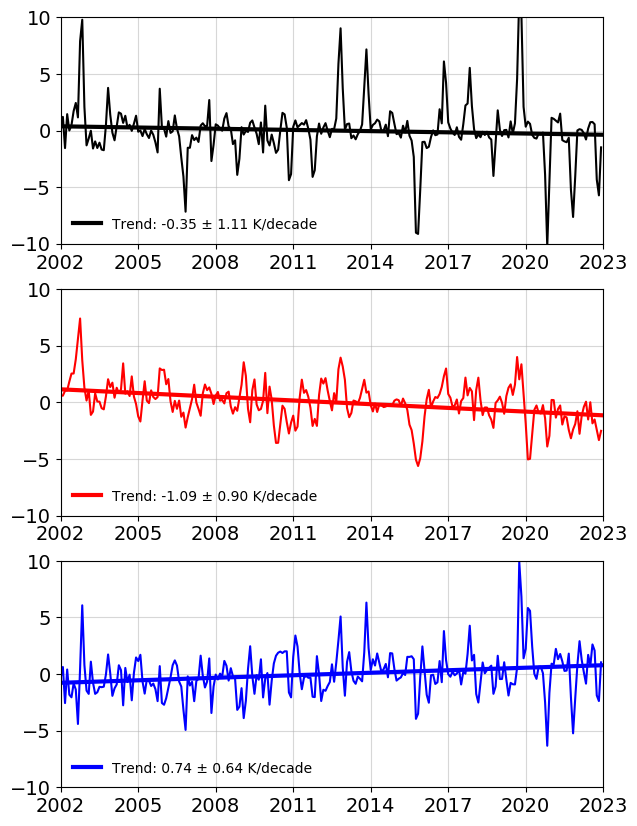

In [12]:
# find location for temperature (should be around 100 hPa and -75 S)
print('Height White Dot: ', zm_temp.alt[80].values)
print('Lat White Dot: ', zm_temp.lat[2].values )#+ 7.5/2)
total_temp = temp_anoms_No_QBO_ENSO_sxx[:,80,2]
circ_temp = projection_timeseries[:,80,2]
diff_temp = residual[:,80,2]

# timeseries array & colors which correspond to timeseries
timeseries_of_interest = [total_temp, circ_temp, diff_temp]
colors = ['black', 'red', 'blue']

# figure creation
fig, axs = plt.subplots(3, 1, figsize=(7,10))

for idx, timeseries in enumerate(timeseries_of_interest):

    # regress timeseries against time & create trend line
    time = np.arange(2002, 2023, 1/12)
    lr = stats.linregress(time, timeseries)
    trend_line = lr[1] + lr[0]*time

    # find residuals from trend line
    errors = timeseries - trend_line
    time_errors = time - np.nanmean(time)

    # find degrees of freedom with autocorrelation
    N = len(timeseries)
    r1_autocorrelation = stats.pearsonr(timeseries[1:], timeseries[:-1])[0]
    N_star = N*((1-r1_autocorrelation)/(1+r1_autocorrelation))

    # find squared error in x and y
    sum_squared_error_res = np.sum(np.square(errors))
    var_errors = (1/N_star)*sum_squared_error_res
    time_squared_error = np.sum(np.square(time_errors))

    # find t-statistic
    simga_slope_squared = var_errors/time_squared_error
    sa = np.sqrt(simga_slope_squared)

    # get critical t value
    tcrit = stats.t.ppf(1-0.025, N_star)

    # find confidence interval
    ci_trend = tcrit*sa

    # find degrees of freedom with autocorrelation
    trend_label = f"Trend: {lr[0]*10:.2f} ± {ci_trend*10:.2f} K/decade"
    
    # plot figure
    axs[idx].plot(time, timeseries, color=colors[idx])
    axs[idx].plot(time, trend_line, color=colors[idx], linewidth=3, label=trend_label)

    # set x-ticks
    axs[idx].tick_params(axis='both', which='major', labelsize=14)
    x_vals = np.arange(2002,2024,3)
    axs[idx].set_xticks(x_vals)
    axs[idx].set_xticklabels([str(year) for year in x_vals])

    # include grid and set range
    axs[idx].set_xlim(2002,2023)
    axs[idx].set_ylim(-10,10)
    axs[idx].grid(alpha=0.5)
    axs[idx].legend(frameon=False, loc=3)


#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/AntarcticTimeseriesCirculationRegression', dpi=300)